# **Example - Building and deploying Prophet Forecasting model**

## **Forecasting**

In [3]:
#!pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
m = Prophet()
m.fit(df)

08:13:37 - cmdstanpy - INFO - Chain [1] start processing
08:13:38 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.211807,7.480026,8.944437
3266,2017-01-16,8.536850,7.840879,9.274451
3267,2017-01-17,8.324274,7.587623,9.010786
3268,2017-01-18,8.156907,7.472711,8.818920
3269,2017-01-19,8.168877,7.447202,8.895318


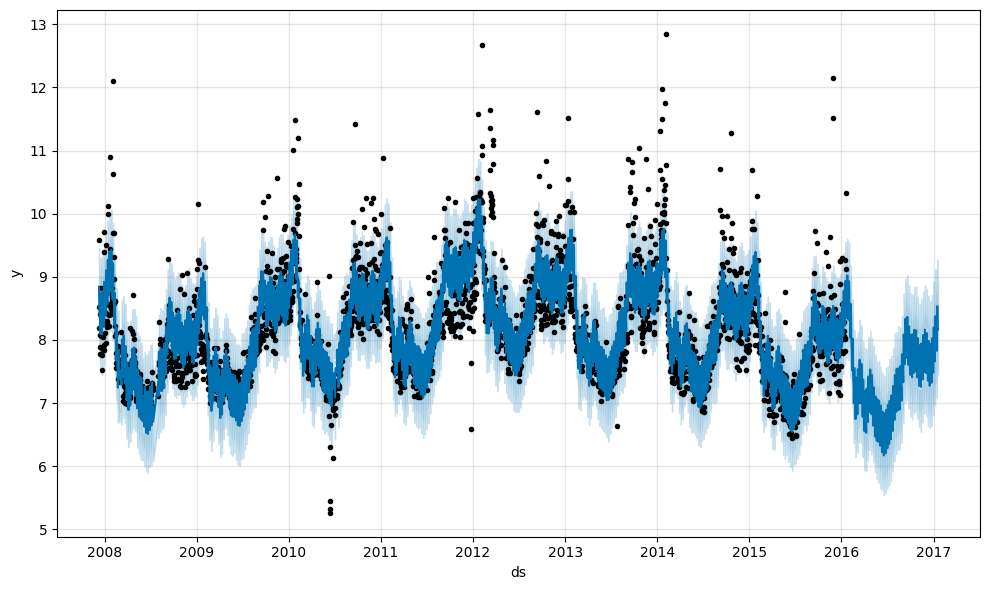

In [6]:
fig1 = m.plot(forecast)



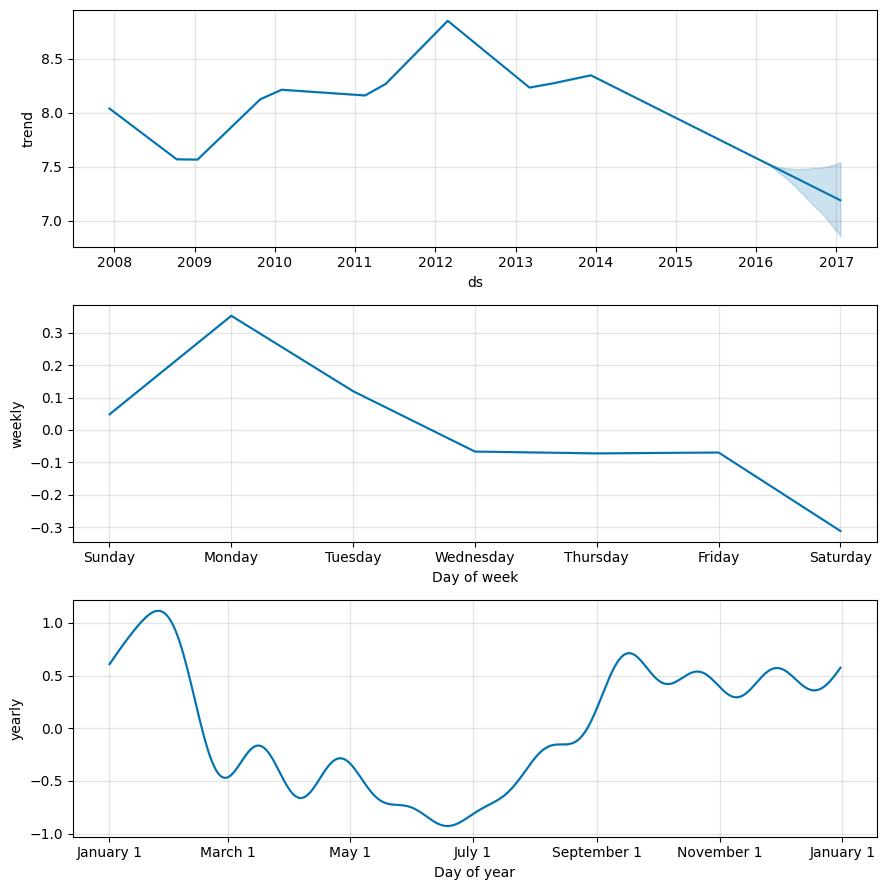

In [7]:
fig2 = m.plot_components(forecast)



## **Model Artifacts**

In [23]:
# !odsc conda init -b conda_environment_yolov5 -n frqap2zhtzbe -a resource_principal
# !odsc conda publish -s tensorflow28_p38_gpu_v1 --force

In [22]:
from ads.model.framework.tensorflow_model import TensorFlowModel
from ads.common.model_metadata import UseCaseType
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os

  from ads.common.model_metadata import UseCaseType

  from ads.common.model_artifact import ModelArtifact

  from ads.common.model_export_util import prepare_generic_model



In [23]:
#path to artifacts and conda slug
path_to_artifacts = './model_artifacts_v1'
conda_env = 'oci://conda_environment_yolov5@frqap2zhtzbe/conda_environments/gpu/TensorFlow 2.8 for GPU on Python 3.8/1.0/tensorflow28_p38_gpu_v1'  

#create default artifacts
artifact = prepare_generic_model(
    path_to_artifacts, 
    fn_artifact_files_included=False, 
    force_overwrite=True, 
    inference_conda_env=conda_env)

  artifact = prepare_generic_model(



loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
%%writefile ./model_artifacts_v1/score.py

import pandas as pd
import numpy as np
import uuid
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import ads
import os


def load_model():
    class DummyModel:
        def __init__(self):
            pass
    return DummyModel()


############################
############################


def predict(data, model=load_model()):
    
    #load data from josn
    df_input = pd.read_json(data['data'])
    
    m = Prophet()
    m.fit(df_input)
    
    future = m.make_future_dataframe(periods=365)
    future.tail()

    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    forecast_as_json = forecast.to_json()

    
    return {'forecast':forecast_as_json}

Overwriting ./model_artifacts_v1/score.py


## **Build JSON data**

In [27]:
## dataframe to json
# json = df.to_json()

# data = {'data':json}

# forecast_as_json = predict(data)
# df_output = pd.read_json(forecast_as_json['forecast'])
# df_output

## **Store the model and deploy**

In [25]:
artifact.introspect()

['score.py', 'runtime.yaml', 'test_json_output.json']


,Test key,Test name,Result,Message
0,runtime_env_path,Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is set,Passed,
1,runtime_env_python,Check that field MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION is set to a value of 3.6 or higher,Passed,
2,runtime_path_exist,Check that the file path in MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is correct.,Passed,
3,runtime_version,Check that field MODEL_ARTIFACT_VERSION is set to 3.0,Passed,
4,runtime_yaml,"Check that the file ""runtime.yaml"" exists and is in the top level directory of the artifact directory",Passed,
5,score_load_model,Check that load_model() is defined,Passed,
6,score_predict,Check that predict() is defined,Passed,
7,score_predict_arg,Check that all other arguments in predict() are optional and have default values,Passed,
8,score_predict_data,"Check that the only required argument for predict() is named ""data""",Passed,
9,score_py,"Check that the file ""score.py"" exists and is in the top level directory of the artifact directory",Passed,


In [26]:
import ads
ads.set_auth(auth='resource_principal')

catalog_entry = artifact.save(display_name='forecasting_v1', description='forecasting_v1', timeout=600)
catalog_entry.id

  catalog_entry = artifact.save(display_name='forecasting_v1', description='forecasting_v1', timeout=600)



loop1:   0%|          | 0/5 [00:00<?, ?it/s]

'ocid1.datasciencemodel.oc1.eu-frankfurt-1.amaaaaaangencdyau6te46r2mejl3zhozp76jy2rqc3zysj7ypi24xaxvmqa'

## **Invoke the Model Deployment HTTP Endpoint**

In [10]:
%%time
import requests
import oci
from oci.signer import Signer
import json


url = "https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaangencdyackngo7q7bmuaqiczil6sxufuv5l7f2t3m2lb3cxoyi3q/predict"

auth = oci.auth.signers.get_resource_principals_signer()

#POST request to the model
response = requests.post(url, json=data, auth=auth)
print(response)
print(json.loads(response.content))

full_response = json.loads(response.content)

<Response [500]>
{"code": "InternalServerError", "message": "Object of type DataFrame is not JSON serializable", "status": "Object of type DataFrame is not JSON serializable"}
CPU times: user 52.9 ms, sys: 2.79 ms, total: 55.7 ms
Wall time: 1.29 s


In [ ]:
df_output = pd.read_json(full_response['forecast'])
df_output